In [15]:
import pandas as pd

# path_cut = 'rat9-examples/rat9-control1_1000-frames_no-clipping.h5'
# path_uncut = 'rat9-examples/rat9-control1_1000-frames_with-clipping.h5'

path_cut = 'rat8-control1_with-yolo.h5'
path_uncut = 'rat8-control1_no-yolo.h5'

df_cut = pd.read_hdf(path_cut)
df_uncut = pd.read_hdf(path_uncut)

In [17]:
idx_slice = pd.IndexSlice

foo = lambda x: (x.loc[:, idx_slice[:,:,'likelihood']] > 0.8).sum(axis=1)
foo(df_cut)

0        1
1        1
2        3
3        5
4        1
        ..
12754    2
12755    0
12756    1
12757    2
12758    0
Length: 11397, dtype: int64

# Performance

Here we can see the darknet 'cut' model appears to perform slightly better 

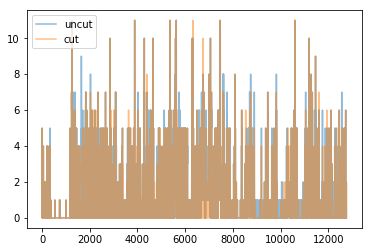

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(foo(df_uncut), label='uncut', alpha=0.5)
plt.plot(foo(df_cut), label='cut', alpha=0.5)
plt.legend()

## Rolling avg

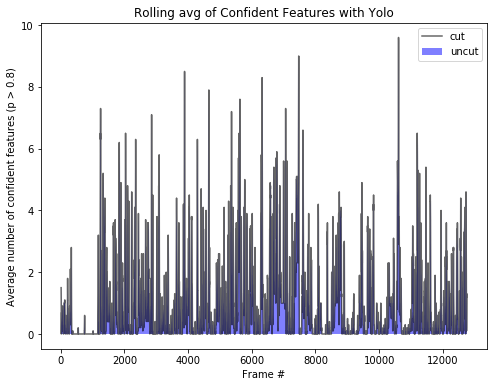

In [23]:
rolling_foo = lambda x: foo(x).rolling(10).mean()

x = np.linspace(0, df_uncut.shape[0], df_uncut.shape[0])
y1 = rolling_foo(df_uncut)
y2 = rolling_foo(df_uncut)

plt.figure(figsize=(8,6))
plt.plot(y1, label='cut', alpha=0.6, color='black')
plt.fill_between(x, y1, 0, where=y2>=y1, label='uncut', alpha=0.5, facecolor='blue')
plt.title('Rolling avg of Confident Features with Yolo')
plt.xlabel('Frame #')
plt.ylabel('Average number of confident features (p > 0.8)')
plt.legend()

# Difference Between Cut vs Uncut

Text(0.5, 0, 'Frame #')

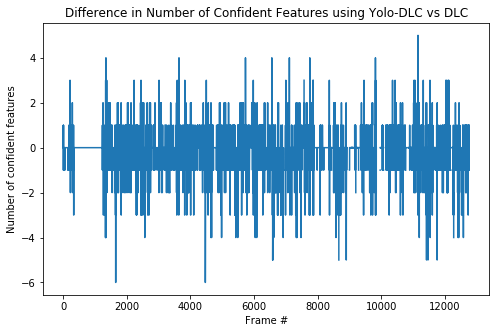

In [20]:
plt.figure(figsize=(8,5))
plt.plot(foo(df_cut) - foo(df_uncut))
plt.title('Difference in Number of Confident Features using Yolo-DLC vs DLC')
plt.ylabel('Number of confident features')
plt.xlabel('Frame #')

In [60]:
foo(df_cut)[foo(df_cut).rolling(10).mean() > 5]

Series([], dtype: int64)

In [21]:
foo(df_uncut).sum()

13520

In [22]:
foo(df_cut).sum()

11934

# Extract Frames with Confident Features

In [186]:
import numpy as np

n_rolling = 5  
p_cutoff = 0.8

df = pd.read_hdf('rat8-control1_yolo-dlc.h5')
def sample_frames_by_features(df, n_samples=100):
    df = df.copy()
    df = df.loc[:, idx_slice[:,:,'likelihood']]
    df[df < p_cutoff] = 0
    p = df.rolling(5).sum().sum(axis=1) # Get the rolling sums for likelihood for each row
    p = p**2 # This will cause differences to be more extreme
    p = p / p.sum() # Normalize    
    return np.random.choice(np.arange(0, df.shape[0]), size=n_samples, replace=False, p=p)

selected_indices = sample_frames_by_features(df)
selected_indices

array([ 9699,  1248,  6739,  3883, 10452, 12526,  2350,  6868,  7609,
        1384,  4288,  5628, 12456,  8901, 12603,  2492,  2741, 11047,
        6298,  1325,  7392, 10608,  1237,  3885, 11052, 11200,  6321,
        7405, 11037, 11307,  6702,  5908,  2340,  5335, 12108,  4028,
        5580,  5029,  9818,  3636,  7350, 10607,  7003, 10613,    98,
        4287,  7433, 10435,  7000,  7474,  6007,  1251, 12685, 11468,
       12568,  2224,  6292, 12556, 12697,  5245,  6570,  5359,  3841,
        1747,  7464,  4294,  5364,  7467, 11332,  8104,  5756,  1832,
        7396, 11196,  5124, 12453,  6571,  7268, 11466,  7390,  7569,
        5243,  1290,  6770,  1826,  4280,  2735, 10603, 10610,  3079,
       11943,  3887,  9631,  6697,  5358,  2517,  6889, 12604,  8806,
        3017])

In [174]:
df.loc[:, idx_slice[:,:,'likelihood']].iloc[7784]

scorer       bodyparts         coords    
dlc-darknet  nose              likelihood    0.048664
             left-ear          likelihood    0.299231
             right-ear         likelihood    0.667150
             left-eye-top      likelihood    0.799225
             left-eye-bottom   likelihood    0.864315
             left-eye-front    likelihood    0.886628
             left-eye-back     likelihood    0.950562
             right-eye-top     likelihood    0.014068
             right-eye-bottom  likelihood    0.084605
             right-eye-front   likelihood    0.279131
             right-eye-back    likelihood    0.026067
             tail-base         likelihood    0.018807
             left-rear-paw     likelihood    0.004416
             right-rear-paw    likelihood    0.002714
             left-front-paw    likelihood    0.039852
             right-front-paw   likelihood    0.081685
Name: 7784, dtype: float64

# Extract Frames

In [187]:
import cv2
import os
from pathlib import Path

cap = cv2.VideoCapture("/storage/gs/rat-emotion/videos/24fps/rat8-control2.mp4")
save_path = Path("/storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26")

if not os.path.exists(save_path):
    os.makedirs(save_path)

for frame_idx in sorted(selected_indices):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    
#     if not ret:
#         continue
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imsave(save_path / f"frame{frame_idx}.png", frame)

In [178]:
! rm -rf {save_path}

In [181]:
! gsutil rm -r gs://rat-emotion/dlc/frames-to-label/2020-06-26

Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame114.png#1593151901672357...
Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame1239.png#1593151903448245...
Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame1246.png#1593151907461453...
Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame1248.png#1593151905227951...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame1249.png#1593151902101749...
Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame1251.png#1593151907076173...
Removing gs://rat-emotion/dlc/frames-to-label/2020-06-26/frame1383.png#1593151903002557...
Removing gs://rat-emotion/dlc/f

In [188]:
ls {save_path}

frame114.png   frame1251.png  frame1747.png  frame2094.png  frame2517.png
frame1237.png  frame1290.png  frame1826.png  frame2224.png  frame55.png
frame1239.png  frame1325.png  frame1827.png  frame2340.png  frame98.png
frame1246.png  frame1383.png  frame1832.png  frame2350.png
frame1248.png  frame1384.png  frame1881.png  frame2352.png
frame1249.png  frame1536.png  frame1930.png  frame2492.png


In [189]:
! gsutil cp -r {save_path} gs://rat-emotion/dlc/frames-to-label/2020-06-26

Copying file:///storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26/frame114.png [Content-Type=image/png]...
Copying file:///storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26/frame1747.png [Content-Type=image/png]...
Copying file:///storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26/frame1249.png [Content-Type=image/png]...
Copying file:///storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26/frame1290.png [Content-Type=image/png]...
\ [4 files][  8.4 MiB/  8.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26/frame2224.png [Content-Type=image/png]...
Copying file:///storage/gs/rat-emotion/dlc/frames-to-label/2020-06-26/frame2350.png [Content-Type=image/png]

## Extract Clips with Confident Features

In [12]:
import cv2
import pandas as pd

output_video = 'confident-test.mp4'
input_video = "/storage/gs/rat-emotion/videos/24fps/rat8-control1.mp4"
data_path = 'rat8-control1_with-yolo.h5'
codec = 'mp4v'
n_frames = 240

cap = cv2.VideoCapture(input_video)
assert cap.isOpened()
FPS = int(cap.get(cv2.CAP_PROP_FPS))
width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*codec)
writer = cv2.VideoWriter(output_video, fourcc, FPS, (width, height))

def get_part_with_most_features(df, pcutoff=0.5):
    idx_slice = pd.IndexSlice
    df = df.copy()
    df = df.loc[:, idx_slice[:,:,'likelihood']]
    df = df[df > pcutoff]
    df = df.count(axis=1).rolling(n_frames).mean()
    return df.argmax()

df = pd.read_hdf(data_path)
idx = get_part_with_most_features(df)
assert cap.set(cv2.CAP_PROP_POS_FRAMES, idx - n_frames)

for frame_idx in range(n_frames):
    if frame_idx % 10 == 0:
        print(frame_idx)
        
    ret, frame = cap.read()
    writer.write(frame)
    
writer.release()
cap.release()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


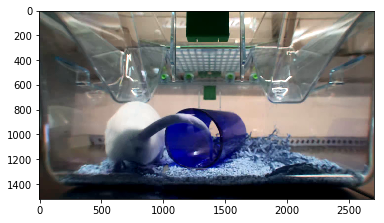

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(frame)

In [13]:
import deeplabcut
deeplabcut.analyze_videos()

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


TypeError: analyze_videos() missing 2 required positional arguments: 'config' and 'videos'

False